# Tutorial: (Stochastic) Poisson Surface Reconstruction

This notebook will show how to use (Stochastic) Poisson Surface Reconstruction [[1](https://hhoppe.com/poissonrecon.pdf),[2](https://www.dgp.toronto.edu/projects/stochastic-psr/)] to reconstruct a surface from an oriented point cloud using Python and `gpytoolbox` [[3](https://gpytoolbox.org)].  

All prerequisites can be installed with pip and conda.
<!-- ```bash
pip install gpytoolbox=0.0.3
pip install numpy
pip install scipy
pip install matplotlib
``` -->

### Prerequisites

We can install all prerequisites with pip

## Poisson Surface Reconstruction [[1](https://hhoppe.com/poissonrecon.pdf)]

The input to this algorithm is an oriented point cloud: a set of tuples $\{(p_i,\vec{n}_i)\}_{i=1}^n$ where $p_i\in\mathbb{R}^d$ are points on an object's surface and $\vec{n}_i\in\mathbb{R}^d$ are the corresponding surface normals at each point. In `gpytoolbox`, we will store this type of data in two matrices $\mathbf{P},\mathbf{N}\in\mathbb{R}^{n\times d}$, such that the i-th row of $\mathbf{P}$ contains the coordinates $p_i$ and the i-th row of $\mathbf{N}$ contains the coordinates of $\vec{n}_i$. Let's begin by generating and plotting a simple example point cloud using basic `numpy` and `matplotlib`.

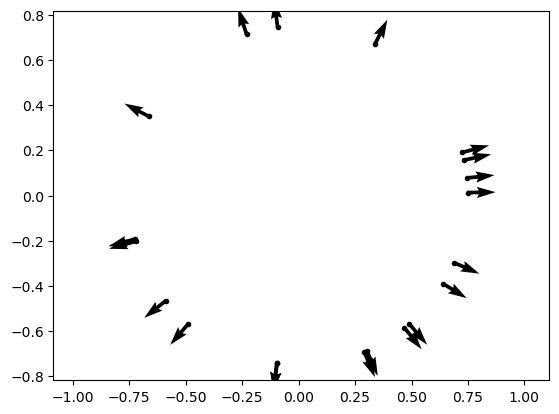

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Seed random generator
rng = np.random.default_rng(0)
th = 2*np.pi*rng.random(20)[:,None] # Random angular values in radians
# th = 2*np.pi*np.random.rand(20,1) # Random angular values in radians
# Random points on a circunference
P = 0.75*np.concatenate((np.cos(th),np.sin(th)),axis=1)
# Normals are the same as positions on a circle
N = np.concatenate((np.cos(th),np.sin(th)),axis=1)
_ = plt.plot(P[:,0],P[:,1],'.k')
_ = plt.quiver(P[:,0],P[:,1],N[:,0],N[:,1])
_ = plt.axis('equal')

From this oriented point cloud, Poisson Surface Reconstruction outputs a scalar function $f:\mathbb{R}^d\rightarrow \mathbb{R}$ which takes negative values inside the reconstructed surface and positive values outside. Specifically, `gpytoolbox` will obtain this function by using a regular grid and the output will be a vector of values at each grid point, together with the coordinates of each grid point.

In [2]:
from gpytoolbox import poisson_surface_reconstruction
gs = np.array([50,50]) # Size of the grid
f, grid_vertices = poisson_surface_reconstruction(P,N,gs=gs)

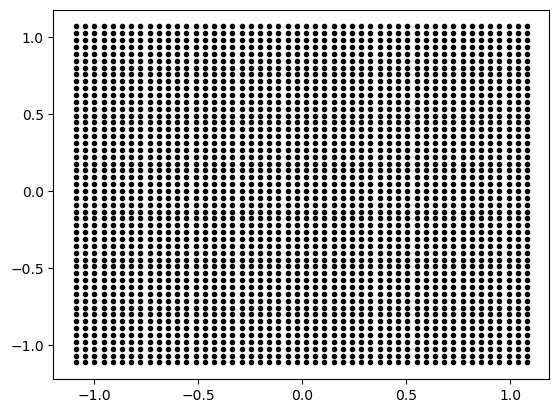

In [3]:
# Let's study the output. grid_vertices is just a list of the grid points with a consistent ordering, like the output of numpy.meshgrid. In 2D:
gx = grid_vertices[0] # x coordinates of the grid points
gy = grid_vertices[1] # y coordinates of the grid points
_ = plt.plot(gx,gy,'.k')

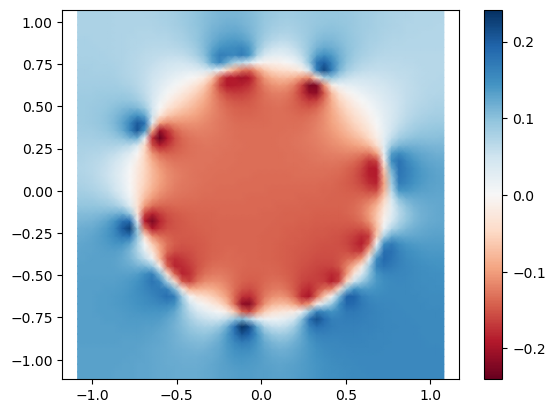

In [4]:
# On the other hand, f will be a vector of the same size as the grid, with the values of the function at each grid point. We can visualize it with matplotlib:
_ = plt.pcolormesh(gx,gy,f.reshape(gs[0],gs[1]),shading='gouraud',cmap='RdBu')
_ = plt.colorbar()
_ = plt.axis('equal')

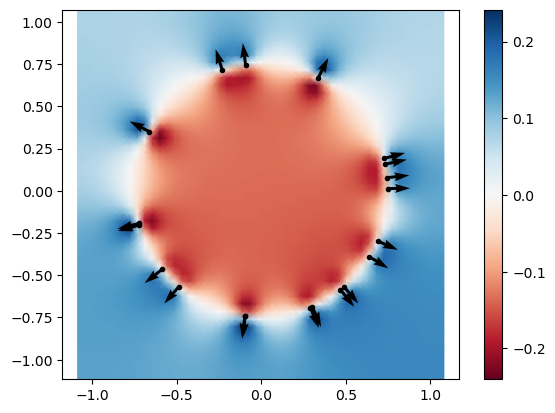

In [5]:
# We can plot it together with the original points to make sure it makes sense:

_ = plt.pcolormesh(gx,gy,f.reshape(gs[0],gs[1]),shading='gouraud',cmap='RdBu')
_ = plt.colorbar()
_ = plt.plot(P[:,0],P[:,1],'.k')
_ = plt.quiver(P[:,0],P[:,1],N[:,0],N[:,1])
_ = plt.axis('equal')

As expected, the values of f that are inside the circle tend to be negative, while those outside tend to be positive. We can extract the reconstructed surface by computing the function's isocontour; i.e., the points $x\in\mathbb{R}^d$ that satisfy $f(x)=0$.

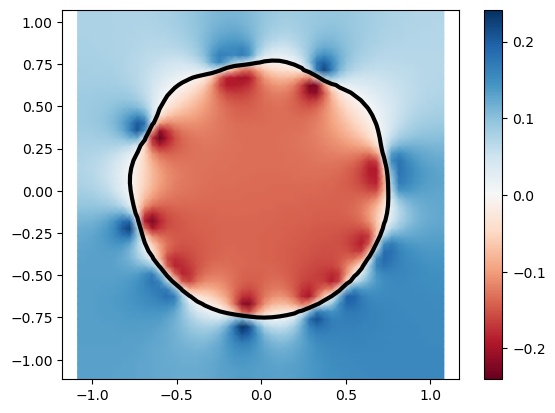

In [6]:
_ = plt.pcolormesh(gx,gy,f.reshape(gs[0],gs[1]),shading='gouraud',cmap='RdBu')
_ = plt.colorbar()
_ = plt.contour(gx,gy,np.reshape(f,gx.shape), np.array([0.0]), colors='k',linewidths=3)
_ = plt.axis('equal')

The output `f` of `gpytoolbox`'s `poisson_surface_reconstruction` are the scalar function values at each grid point. However, in certain applications we may want to turn this into a function that we can sample anywhere in $\mathbb{R}^d$. We can use `gpytoolbox` for this as well:

In [7]:
from gpytoolbox import fd_interpolate
# We need the grid parameters, which we can get from the grid_vertices
grid_vertices_as_array = np.array(grid_vertices).reshape(2, -1).T # Reshape to a 2D array
corner = grid_vertices_as_array.min(axis=0)
h = (grid_vertices_as_array.max(axis=0) - grid_vertices_as_array.min(axis=0))/gs
def scalar_function(X):
    W = fd_interpolate(X,gs,h,corner)
    return W @ f

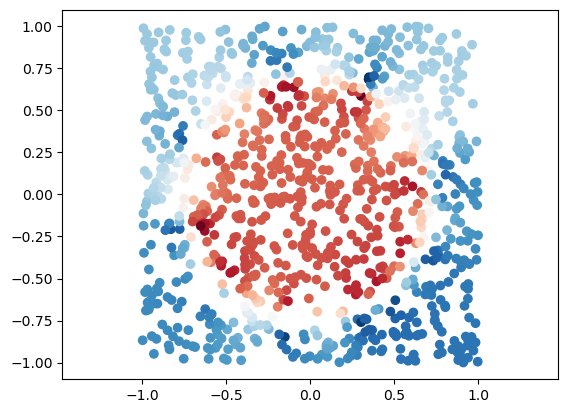

In [8]:
# Now we can sample at any number of randomly selected points
X = 2*np.random.rand(1000,2) - 1
fun_at_X = scalar_function(X)
# And plot the result
_ = plt.scatter(X[:,0],X[:,1],c=fun_at_X,cmap='RdBu')
# (please note that the values outside of the grid will default to zero, since those cannot be interpolated)
_ = plt.axis('equal')

## Stochastic Poisson Surface Reconstruction [[2](https://www.dgp.toronto.edu/projects/stochastic-psr/)]
Poisson Surface Reconstruction outputs a scalar function and, through it, a possible reconstructed surface. However, it ignores a key fact: surface reconstruction is, fundamentally, an under-determined problem, and there are infinitely many possible reconstructed surfaces. *Stochastic* Poisson Surface Reconstruction formalizes this intuition by instead of computing a function $f:\mathbb{R}^d\rightarrow \mathbb{R}$, modeling it as a Gaussian distribution
$$f(x)\sim \mathcal{N}(\mu(x),\sigma(x))$$
and computing the functions $\mu:\mathbb{R}^d\rightarrow \mathbb{R}$ and $\sigma:\mathbb{R}^d\rightarrow \mathbb{R}^+$. In `gpytoolbox`, it's as easy as including the `stochastic=True` flag in our call to `poisson_surface_reconstruction`:


In [9]:
mean, variance, grid_vertices = poisson_surface_reconstruction(P,N,gs=gs,stochastic=True)

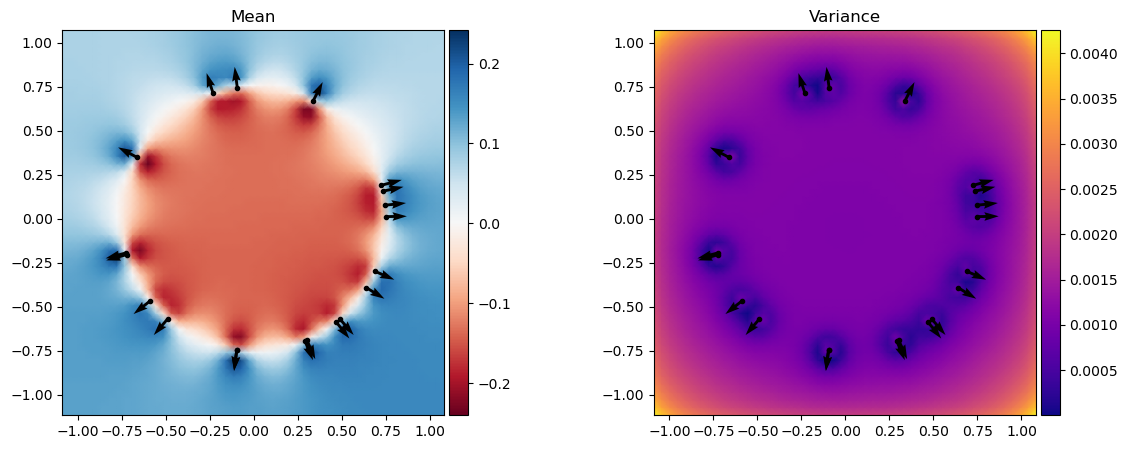

In [10]:
# Let's plot mu and sigma together with the original points to make sure it makes sense:
f, ax = plt.subplots(1,2,figsize=(14,5))

m0 = ax[0].pcolormesh(gx,gy,mean.reshape(gs[0],gs[1]),shading='gouraud',cmap='RdBu')
# This just adds a colorbar to this subplot:
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(m0, cax=cax, orientation='vertical')
# Add colorbar
# plt.colorbar(m0,cax=ax[0])
_ = ax[0].plot(P[:,0],P[:,1],'.k')
_ = ax[0].quiver(P[:,0],P[:,1],N[:,0],N[:,1])
_ = ax[0].axis('equal')
_ = ax[0].set_title('Mean')

m1 = ax[1].pcolormesh(gx,gy,variance.reshape(gs[0],gs[1]),shading='gouraud',cmap='plasma')
# This just adds a colorbar to this subplot:
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(m1, cax=cax, orientation='vertical')
# Add colorbar
# plt.colorbar(m0,cax=ax[0])
_ = ax[1].plot(P[:,0],P[:,1],'.k')
_ = ax[1].quiver(P[:,0],P[:,1],N[:,0],N[:,1])
_ = ax[1].axis('equal')
_ = ax[1].set_title('Variance')

### Statistical queries
As expected, the mean of the distribution looks identical to the original Poisson Surface Reconstruction output, but we are now also endowed with a variance, which fully determine a Gaussian distribution of the scalar function at each point in space. This means we can compute useful statistical queries; for example, the probability that each point in space has of being inside the reconstructed surface,
$$v(x) = p(f(x)\leq 0)$$

Unlike the traditional PSR output, this is a value between zero and one that can be interpreted as a probability:

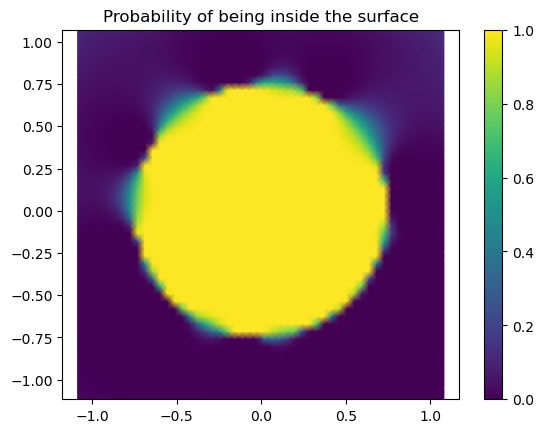

In [11]:
from scipy.stats import norm
prob_out =  1 - norm.cdf(mean,0,np.sqrt(variance))
_ = plt.pcolormesh(gx,gy,prob_out.reshape(gs[0],gs[1]),shading='gouraud',cmap='viridis')
_ = plt.colorbar()
_ = plt.title("Probability of being inside the surface")
_ = plt.axis('equal')

As expected, the probability sharply transitions from zero to one near the data, and more smoothly transitions in surface regions with little information.  

Let $g_{\mu,\sigma}$ be the standard Gaussian density function with mean $\mu$ and variance $\sigma$. Another statistical quantity that we can compute is each point's probability density at the zero function value, which can be interpreted to be proportional to the probability of each point being *on* the reconstructed surface:  
$$s(x) = g_{\mu(x),\sigma(x)}(0)$$

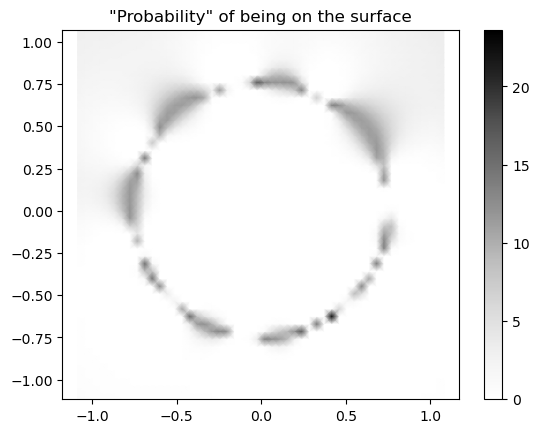

In [12]:
prob_on = norm.pdf(np.zeros(mean.shape),loc=mean,scale=np.sqrt(variance))
# prob_on =  1 - norm.cdf(mean,0,np.sqrt(variance))
_ = plt.pcolormesh(gx,gy,prob_on.reshape(gs[0],gs[1]),shading='gouraud',cmap='Greys')
_ = plt.colorbar()
_ = plt.title("\"Probability\" of being on the surface")
_ = plt.axis('equal')

While we are obtaining the correct values for $v(x)$ and $s(x)$ at the grid points, it is a bit disappointing that they look so pixelated when plotting. This is specially clear in the last example, where the surface probability is at times so thinly supported that its support falls below the grid spacing and gives the appearance that there is no surface when plotted. Using `gpytoolbox`, we can actually plot the values of these statistical queries on a finer grid:

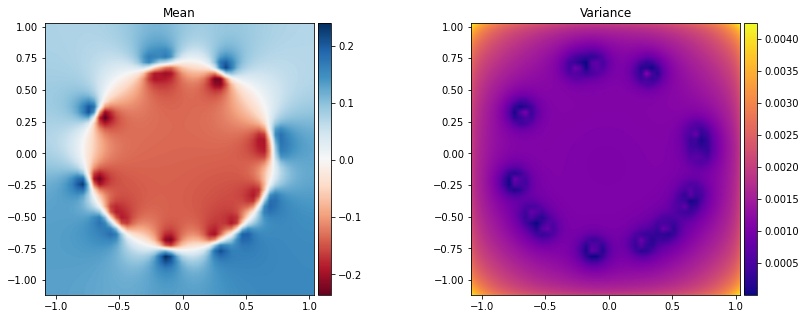

In [ ]:
how_many_times_bigger = 8
gs_big = how_many_times_bigger * gs
gx_big, gy_big = np.meshgrid(np.linspace(corner[0],corner[0] + h[0]*(gs[0]-1),how_many_times_bigger*gs[0]),np.linspace(corner[1],corner[1] + h[1]*(gs[1]-1),how_many_times_bigger*gs[1]))
verts_big = np.concatenate((np.reshape(gx_big,(-1, 1)),np.reshape(gy_big,(-1, 1))),axis=1) # As a vertex list
# We can now interpolate the mean and variance at these points:
W = fd_interpolate(verts_big,gs,h,corner)
mean_big = W @ mean
variance_big = W @ variance
# And plot the result
# Of course, the mean and variance on the large grid will look similar, since matplotlib was already interpolating them to the screen resolution:

f, ax = plt.subplots(1,2,figsize=(14,5))

m0 = ax[0].pcolormesh(gx_big,gy_big,mean_big.reshape(gs_big[0],gs_big[1]),shading='gouraud',cmap='RdBu')
# This just adds a colorbar to this subplot:
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(m0, cax=cax, orientation='vertical')
# Add colorbar
# plt.colorbar(m0,cax=ax[0])
_ = ax[0].axis('equal')
_ = ax[0].set_title('Mean')

m1 = ax[1].pcolormesh(gx_big,gy_big,variance_big.reshape(gs_big[0],gs_big[1]),shading='gouraud',cmap='plasma')
# This just adds a colorbar to this subplot:
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(m1, cax=cax, orientation='vertical')
# Add colorbar
# plt.colorbar(m0,cax=ax[0])
_ = ax[1].axis('equal')
_ = ax[1].set_title('Variance')

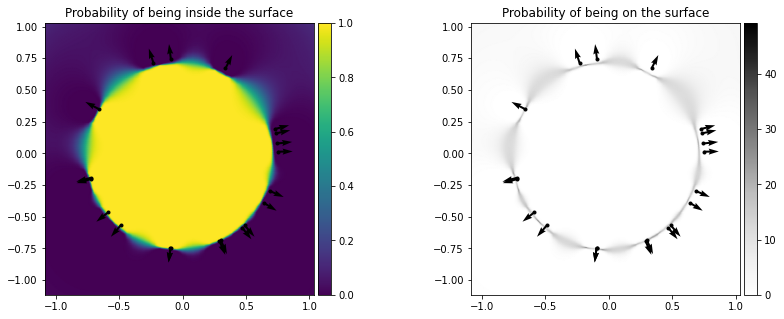

In [ ]:
# Now, let's compute the statistical queries on the big grid:
prob_out_big = 1 - norm.cdf(mean_big,0,np.sqrt(variance_big))
prob_on_big = norm.pdf(np.zeros(mean_big.shape),loc=mean_big,scale=np.sqrt(variance_big))
f, ax = plt.subplots(1,2,figsize=(14,5))

m0 = ax[0].pcolormesh(gx_big,gy_big,prob_out_big.reshape(gs_big[0],gs_big[1]),shading='gouraud',cmap='viridis')
# This just adds a colorbar to this subplot:
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(m0, cax=cax, orientation='vertical')
# Add colorbar
# plt.colorbar(m0,cax=ax[0])
_ = ax[0].plot(P[:,0],P[:,1],'.k')
_ = ax[0].quiver(P[:,0],P[:,1],N[:,0],N[:,1])
_ = ax[0].axis('equal')
_ = ax[0].set_title('Probability of being inside the surface')

m1 = ax[1].pcolormesh(gx_big,gy_big,prob_on_big.reshape(gs_big[0],gs_big[1]),shading='gouraud',cmap='Greys')
# This just adds a colorbar to this subplot:
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(m1, cax=cax, orientation='vertical')
# Add colorbar
# plt.colorbar(m0,cax=ax[0])
_ = ax[1].plot(P[:,0],P[:,1],'.k')
_ = ax[1].quiver(P[:,0],P[:,1],N[:,0],N[:,1])
_ = ax[1].axis('equal')
_ = ax[1].set_title('Probability of being on the surface')


### Subspace reduction
Using a larger grid is a much clearer way of visualizing the computed statistical quantities that have features below the scale of grid resolution. Of course, another option would be to carry out the whole computation on a larger grid, but this will have a larger associated computational cost. When this is the case (this is especially necessary in 3D applications), we can use a space reduction technique (see Section 4.2. in [[2](https://www.dgp.toronto.edu/projects/stochastic-psr/stochastic-psr-lr.pdf)]) to reduce the computational cost. In the `gpytoolbox` implementation, this is done by adding a `solve_subspace_dim` argument. The higher the value, the lower the approximation error will be at a higher computational cost. In practice, values between 1,000 and 10,000 are reasonable.

In [ ]:
# Let's try to solve on a finer grid:
import time
t0 = time.time()
how_much_finer = 2 # Make this bigger for more exaggerate results
finer_gs = how_much_finer * gs
mean_slow, variance_slow, grid_vertices_slow = poisson_surface_reconstruction(P,N,gs=finer_gs,stochastic=True)
print("Time to solve: ",time.time() - t0)

Time to solve:  40.449671030044556


In [ ]:
# Now let's solve using the subspace reduction trick:
t0 = time.time()
mean_fast, variance_fast, grid_vertices_fast = poisson_surface_reconstruction(P,N,gs=finer_gs,stochastic=True,solve_subspace_dim=1000)
print("Time to solve: ",time.time() - t0)

Time to solve:  2.7511565685272217


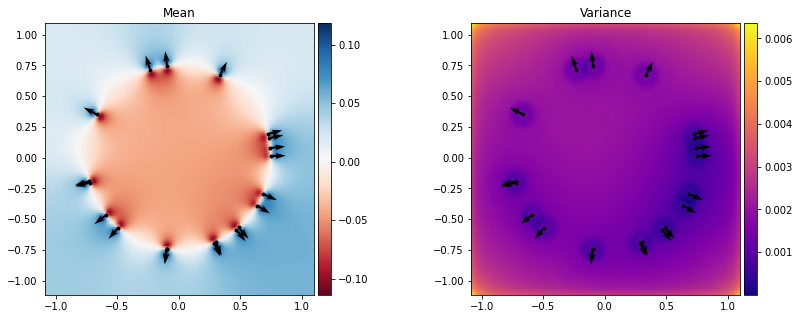

In [ ]:
# Let's plot the fast result:
f, ax = plt.subplots(1,2,figsize=(14,5))

m0 = ax[0].pcolormesh(grid_vertices_fast[0],grid_vertices_fast[1],mean_fast.reshape(finer_gs[0],finer_gs[1]),shading='gouraud',cmap='RdBu')
# This just adds a colorbar to this subplot:
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(m0, cax=cax, orientation='vertical')
_ = ax[0].plot(P[:,0],P[:,1],'.k')
_ = ax[0].quiver(P[:,0],P[:,1],N[:,0],N[:,1])
# Add colorbar
# plt.colorbar(m0,cax=ax[0])
_ = ax[0].axis('equal')
_ = ax[0].set_title('Mean')

m1 = ax[1].pcolormesh(grid_vertices_fast[0],grid_vertices_fast[1],variance_fast.reshape(finer_gs[0],finer_gs[1]),shading='gouraud',cmap='plasma')
# This just adds a colorbar to this subplot:
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(m1, cax=cax, orientation='vertical')
_ = ax[1].plot(P[:,0],P[:,1],'.k')
_ = ax[1].quiver(P[:,0],P[:,1],N[:,0],N[:,1])
# Add colorbar
# plt.colorbar(m0,cax=ax[0])
_ = ax[1].axis('equal')
_ = ax[1].set_title('Variance')

### Reconstruction priors
Stochastic Poisson Surface Reconstruction provides a novel understanding of PSR as a supervised learning process, which means one can easily incorporate prior knowledge about the surfaces in the reconstruction. Specifically, one can provide a vector field prior $\vec{v}:\mathbb{R}^d\rightarrow\mathbb{R}^d$ that encondes knowledge about the gradient of the scalar field. This is implemented in `gpytoolbox` through the `prior_fun` flag.

A good example of the use of priors is the recovery of closed surfaces. While the traditional PSR is known to often output open surfaces, including a weak spherical prior enforces closed reconstructions in Stochastic Poisson Surface Reconstruction.

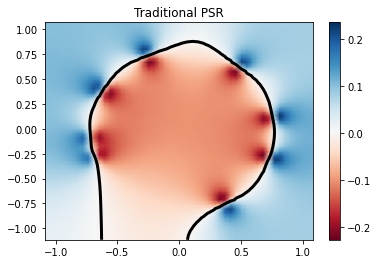

In [ ]:
rng = np.random.default_rng(1)
th = 2*np.pi*rng.random(10)[:,None] # Random angular values in radians
# th = 2*np.pi*np.random.rand(20,1) # Random angular values in radians
# Random points on a circunference
P = 0.75*np.concatenate((np.cos(th),np.sin(th)),axis=1)
# Normals are the same as positions on a circle
N = np.concatenate((np.cos(th),np.sin(th)),axis=1)
f, grid_vertices = poisson_surface_reconstruction(P,N,gs=gs)
_ = plt.pcolormesh(gx,gy,f.reshape(gs[0],gs[1]),shading='gouraud',cmap='RdBu')
_ = plt.colorbar()
_ = plt.contour(gx,gy,np.reshape(f,gx.shape), np.array([0.0]), colors='k',linewidths=3)
_ = plt.title("Traditional PSR")

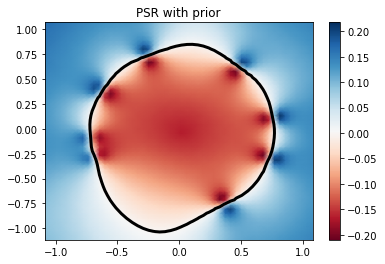

In [ ]:
# Let us include a spherical prior:
def spherical_prior(X):
    normalized_vals =  X/np.tile(np.linalg.norm(X,axis=1),(2,1)).transpose()
    # normalized_vals =  2*X
    #return np.tile(np.array([[1.0,0.0]]),(X.shape[0],1))
    return 0.1*normalized_vals

f_with_prior, grid_vertices = poisson_surface_reconstruction(P,N,gs=gs,prior_fun=spherical_prior)
_ = plt.pcolormesh(gx,gy,f_with_prior.reshape(gs[0],gs[1]),shading='gouraud',cmap='RdBu')
_ = plt.colorbar()
_ = plt.contour(gx,gy,np.reshape(f_with_prior,gx.shape), np.array([0.0]), colors='k',linewidths=3)
_ = plt.title("PSR with prior")

### More complex 2D examples

A nice way of coming up with nice 2D toy examples for prototyiping is to use `gpytoolbox` to load curves from png files (with `gpytoolbox.png2poly`) and sample random points from them (using `random_points_on_mesh`). Here's an example used in [[2](https://www.dgp.toronto.edu/projects/stochastic-psr/)]

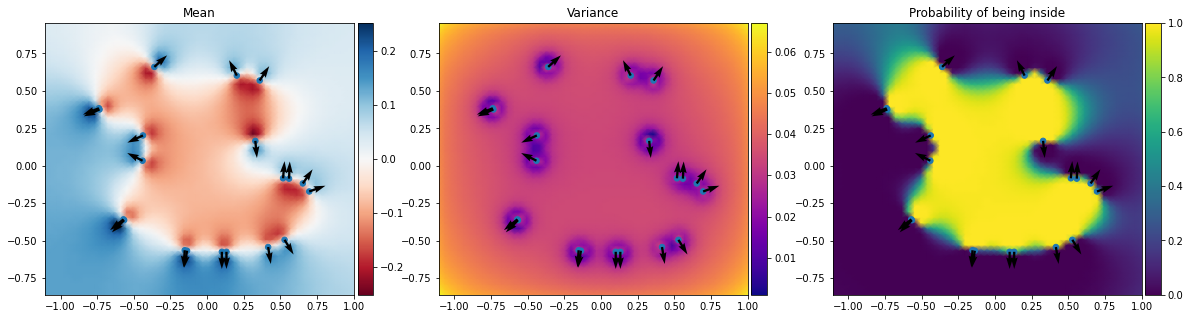

In [ ]:
# The same works for more complex shapes:
from gpytoolbox import png2poly, random_points_on_mesh, edge_indices
poly = png2poly("https://raw.githubusercontent.com/sgsellan/gpytoolbox/main/test/unit_tests_data/illustrator.png")[0]
poly = poly - np.min(poly)
poly = poly/np.max(poly)
poly = 0.5*poly + 0.25
poly = 3*poly - 1.5
num_samples = 20
np.random.seed(2)
EC = edge_indices(poly.shape[0],closed=False)
P,I,_ = random_points_on_mesh(poly, EC, num_samples, return_indices=True,rng=np.random.default_rng(0))
vecs = poly[EC[:,0],:] - poly[EC[:,1],:]
vecs /= np.linalg.norm(vecs, axis=1)[:,None]
J = np.array([[0., -1.], [1., 0.]])
N = vecs @ J.T
N = N[I,:]

# Problem parameters
gs = np.array([50,50])
# Call to PSR
scalar_mean, scalar_var, grid_vertices = poisson_surface_reconstruction(P,N,gs=gs,solve_subspace_dim=0,stochastic=True)

# The probability of each grid vertex being inside the shape
prob_out = 1 - norm.cdf(scalar_mean,0,np.sqrt(scalar_var))

gx = grid_vertices[0]
gy = grid_vertices[1]

# Plot mean and variance side by side with colormap
fig, ax = plt.subplots(1,3,figsize=(20,5))
m0 = ax[0].pcolormesh(gx,gy,np.reshape(scalar_mean,gx.shape), cmap='RdBu',shading='gouraud', vmin=-np.max(np.abs(scalar_mean)), vmax=np.max(np.abs(scalar_mean)))
ax[0].scatter(P[:,0],P[:,1],30 + 0*P[:,0])
q0 = ax[0].quiver(P[:,0],P[:,1],N[:,0],N[:,1])
ax[0].set_title('Mean')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(m0, cax=cax, orientation='vertical')

m1 = ax[1].pcolormesh(gx,gy,np.reshape(np.sqrt(scalar_var),gx.shape), cmap='plasma',shading='gouraud')
ax[1].scatter(P[:,0],P[:,1],30 + 0*P[:,0])
q1 = ax[1].quiver(P[:,0],P[:,1],N[:,0],N[:,1])
ax[1].set_title('Variance')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(m1, cax=cax, orientation='vertical')

m2 = ax[2].pcolormesh(gx,gy,np.reshape(prob_out,gx.shape), cmap='viridis',shading='gouraud')
ax[2].scatter(P[:,0],P[:,1],30 + 0*P[:,0])
q2 = ax[2].quiver(P[:,0],P[:,1],N[:,0],N[:,1])
ax[2].set_title('Probability of being inside')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(m2, cax=cax, orientation='vertical')
plt.show()

### 3D examples
(Stochastic) Poisson Surface Reconstruction is dimension agnostic, and `gpytoolbox`'s implementation also allows us to use it to compute surfaces in three dimensions. However, the functions $f, \mu, \sigma$ are harder to visualize in this case. One slightly hacky way of doing it is to use the tetrahedral mesh visualizer in `polyscope` [[4](https://polyscope.run/py/)].


In [ ]:
# Does this work to download external files?
!wget https://raw.githubusercontent.com/sgsellan/gpytoolbox/main/test/unit_tests_data/bunny_oded.obj

--2022-12-24 10:57:08--  https://raw.githubusercontent.com/sgsellan/gpytoolbox/main/test/unit_tests_data/bunny_oded.obj
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538169 (526K) [text/plain]
Saving to: ‘bunny_oded.obj’

bunny_oded.obj      100%[===================>] 525.56K  --.-KB/s    in 0.03s   

2022-12-24 10:57:08 (18.1 MB/s) - ‘bunny_oded.obj’ saved [538169/538169]



In [ ]:
# Generate a point cloud
from gpytoolbox import read_mesh, per_face_normals
v,f = read_mesh("bunny_oded.obj")
# print(f.shape)
n = 100
P,I,_ = random_points_on_mesh(v,f,n,return_indices=True)
N = per_face_normals(v,f)[I,:]
gs = 1*np.array([44,44,44]) #44
# Call stochastic PSR
corner = np.array([-1.1,-1.1,-1.1])
h = np.array([0.05,0.05,0.05])/1
scalar_mean, scalar_var, grid_vertices = poisson_surface_reconstruction(P,N,gs=gs,corner=corner,h=h,solve_subspace_dim=3000,stochastic=True)

In [ ]:
# There's no integration with Jupyter notebooks, but here's what you could run to visualize the result in polyscope:


####
# from gpytoolbox import regular_cube_mesh
# import polyscope as ps
# tet_verts, tets = regular_cube_mesh(gs[0],type='hex')
# tet_verts = 2.2*tet_verts - 1.1
# R = np.array([[0.0,0.0,1.0],[0.0,1.0,0.0],[-1.0,0.0,0.0]]) @ np.array([[1.0,0.0,0.0],[0.0,0.0,1.0],[0.0,-1.0,0.0]])
# tet_verts = tet_verts @ R
# tet_verts[:,0] = - tet_verts[:,0]
# tet_verts[:,1] = - tet_verts[:,1]
# ps.init()
# ps_vol = ps.register_volume_mesh("test volume mesh", tet_verts, hexes=tets, enabled=False)
# ps_vol.add_scalar_quantity("mean", scalar_mean)
# ps_vol.add_scalar_quantity("sigma", scalar_var)
# sample_points = ps.register_point_cloud("sample points", P)
# sample_points.add_vector_quantity("sample normals", N, enabled=True)
# ps.show()
####

In [ ]:
# One can also compute the zero level-set surface of the mean field
from skimage.measure import marching_cubes
verts, faces, normals, values = marching_cubes(np.reshape(scalar_mean,(gs[0],gs[1],gs[2]),order='F'),level=0.0)
# skimage's marching cubes outputs a mesh in the [0,gs] interval, so we need to rescale it
verts = verts/(gs-1)
grid_length = gs*h
verts = 2.2*verts - 1.1
# Write mesh
from gpytoolbox import write_mesh
write_mesh("bunny_zero_isolevel.obj",verts,faces)


In [ ]:
# To visualize meshes in google colab, we can use meshplot. This is a trick lifted from Alberto Tono and Alex Naumann:
# https://github.com/skoch9/meshplot/issues/29
# I do still recommend you use polyscope outside of jupyter notebooks
################################################################################
# INSTALL CONDA ON GOOGLE COLAB
################################################################################
# ! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
# ! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
# ! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
# import sys
# sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
# !conda install -c conda-forge meshplot -y

In [ ]:
import meshplot as mp
from IPython.display import display, HTML
p = mp.plot(verts,faces)
html = p.to_html(imports=True, html_frame=False)
display(HTML(html))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0292553…

In [ ]:
# We can visualize the variance on the mesh by interpolating it to the vertices
W = fd_interpolate(verts,gs,h,corner=corner)
var_on_verts = W @ scalar_var
p = mp.plot(verts,faces,c=var_on_verts)
html = p.to_html(imports=True, html_frame=False)
display(HTML(html))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0292553…

In [ ]:
# The relevance of the variance is easier to see if we make the surface incomplete
N = N[P[:,0] < 0,:]
P = P[P[:,0] < 0,:]
scalar_mean, scalar_var, grid_vertices = poisson_surface_reconstruction(P,N,gs=gs,corner=corner,h=h,solve_subspace_dim=3000,stochastic=True)


In [ ]:
verts, faces, normals, values = marching_cubes(np.reshape(scalar_mean,(gs[0],gs[1],gs[2]),order='F'),level=0.0)
# skimage's marching cubes outputs a mesh in the [0,gs] interval, so we need to rescale it
verts = verts/(gs-1)
grid_length = gs*h
verts = 2.2*verts - 1.1
W = fd_interpolate(verts,gs,h,corner=corner)
var_on_verts = W @ scalar_var
p = mp.plot(verts,faces,c=var_on_verts)
html = p.to_html(imports=True, html_frame=False)
display(HTML(html))
# The variance should be higher (more yellow) on the missing side of the mesh

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.232981…

# References
[1] "[Poisson Surface Reconstruction](https://hhoppe.com/poissonrecon.pdf)" by *Michael Kazhdan, Matthew Bolitho and Hugues Hoppe*, 2006.  

[2] "[Stochastic Poisson Surface Reconstruction](https://www.dgp.toronto.edu/projects/stochastic-psr/)" by *Silvia Sellán and Alec Jacobson*, 2022.  

[3] "[Gpytoolbox: A Python Geometry Processing library](https://gpytoolbox.org)" by *Silvia Sellán and Oded Stein*, 2022.